In [1]:
# common
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List
from tqdm import tqdm
from glob import glob
from datetime import datetime

# preprocessing
from tensorflow import image as tfi

# visualization
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Model Evaluate
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# output cell
from IPython.display import clear_output as cls

In [2]:
# Constants
IMAGE_SIZE = 300

# Random Seed
random_seed = 42 # set random seed for reproducibility
tf.random.set_seed(random_seed) # set random seed for TensorFlow
np.random.seed(random_seed) # set random seed for NumPy

# classnames
class_names = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']

In [3]:
def load_image(image_path: str) -> tf.Tensor:
    
    '''
    The task of the function is to load the image present in the specified given image path. Loading the image the function also performed some 
    preprocessing steps such as resizing and normalization.
    
    Argument:
        image_path(str) : This is a string which represents the location of the image file to be loaded.
        
    Returns:
        image(tf.Tensor) : This is the image which is loaded from the given image part in the form of a tensor.
    '''
    
    # Check if image path exists
    assert os.path.exists(image_path), f'Invalid image path: {image_path}'
    
    # Read the image file
    image = tf.io.read_file(image_path)
    
    # Load the image
    try:
        image = tfi.decode_jpeg(image, channels=3)
    except:
        image = tfi.decode_png(image, channels=3)
    
    # Change the image data type
    image = tfi.convert_image_dtype(image, tf.float32)
    
    # Resize the Image
    image = tfi.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    
    # Rescale pixel values to be in the range [0, 1]
    image = tf.image.per_image_standardization(image)
    
    # Convert image data type to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image

In [4]:
def load_dataset(root_path: str, class_names: list, batch_size: int = 32, buffer_size: int = 1000) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Load and preprocess images from the given root path and return them as numpy arrays.

    Args:
        root_path (str): Path to the root directory where all the subdirectories (class names) are present.
        class_names (list): List of the names of all the subdirectories (class names).
        batch_size (int): Batch size of the final dataset. Defaults to 32.
        buffer_size (int): Buffer size to use when shuffling the data. Defaults to 1000.

    Returns:
        Two numpy arrays, one containing the images and the other containing their respective labels.
    '''

    # Collect total number of data samples
    n_samples = sum([len(os.listdir(os.path.join(root_path, name))) for name in class_names])

    # Create arrays to store images and labels
    images = np.empty(shape=(n_samples, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
    labels = np.empty(shape=(n_samples, 1), dtype=np.int32)

    errors = []
    
    # Loop over all the image file paths, load and store the images with respective labels
    n_image = 0
    for class_name in tqdm(class_names, desc="Loading"):
        class_path = os.path.join(root_path, class_name)
        for file_path in glob(os.path.join(class_path, "*")):
            # Load the image
            try:
                image = load_image(file_path)
                
                # Assign label
                label = class_names.index(class_name)

                # Store the image and the respective label
                images[n_image] = image
                labels[n_image] = label

                # Increment the number of images processed
                n_image += 1
                
            except:
                errors.append(file_path)
            
    # Shuffle the data
    # indices = np.random.permutation(n_samples)
    # images = images[indices]
    # labels = labels[indices]
    
    print('num of errors:', len(errors))

    return images, labels, errors

In [5]:
def load_and_preprocess_image(image, label):
    # Resize the image to the desired size
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    
    # Rescale pixel values to be in the range [0, 1]
    image = tf.image.per_image_standardization(image)
    
#     # Convert image data type to tf.float32
#     image = tf.cast(image, tf.float32)
    
    return image, label

In [6]:
def plot_images(dataset: tf.data.Dataset, n_rows: int = 5, n_cols: int = 4, class_names=class_names, figsize=(20, 20), model=None, check=False):
    """
    Plots a grid of images and their corresponding labels from a tf.data.Dataset object.

    Args:
        dataset (tf.data.Dataset): A TensorFlow dataset object containing the images and labels to plot.
        n_rows (int): Number of rows in the plot grid. Default is 1.
        n_cols (int): Number of columns in the plot grid. Default is 4.
        class_names (list): A list of strings mapping the integer labels to their corresponding class names. Default is None.
        figsize (tuple): A tuple specifying the size of the figure. Default is (10, 10).
    """
    
    for images, labels in dataset.take(1):
#     images, labels = next(iter(dataset))
    
        # Create a figure to display the images
        fig = plt.figure(figsize=figsize)

        # Loop over the number of rows and columns
        for i in range(n_rows * n_cols):

            label = int(labels[i].numpy())
            title = "true: "+class_names[label]

            if model:
                pred = model.predict(images[i][np.newaxis])

                if check:
                    if label == np.argmax(pred):
                        continue

                pred_label = f"Pred: {np.argmax(pred)}"
                pred_percentage = f" ({np.max(pred) * 100:.2f}%)"
                if class_names:
                    pred_label += f" ({class_names[np.argmax(pred)]})"
                title += f"\n{pred_label} {pred_percentage}"

            # Create a subplot for each image
            ax = fig.add_subplot(n_rows, n_cols, i+1)    

            # Plot the image
            ax.imshow(images[i].numpy().astype("uint8"))

            # Set the title to the corresponding label
            ax.set_title(title)

            # Remove the axis ticks
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Show the plot
    plt.show()

In [7]:
# load data
# test_dir = '../dataset/old/test/'
test_dir = '../dataset/clean_merged_split_convert_augment/test-augment/'

In [19]:
# Load the testing dataset
X_test, y_test, err_test = load_dataset(root_path = test_dir, class_names = class_names)

Loading: 100%|██████████| 20/20 [00:01<00:00, 11.80it/s]

num of errors: 0


In [8]:
# load model
model_path = '../models/aksara_jawa_vgg_full_freeze_v1.h5'
model = tf.keras.saving.load_model(model_path)

In [162]:
# Make predictions
predictions = model.predict(X_test)
y_pred = predictions.argmax(axis=1)

7/7 [==============================] - 37s 5s/step


In [163]:
# evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f'Test loss, accuracy: {loss:.2f}, {acc:.2f}')

7/7 [==============================] - 37s 5s/step - loss: 1.0576 - accuracy: 0.8218
Test loss, accuracy: 1.06, 0.82


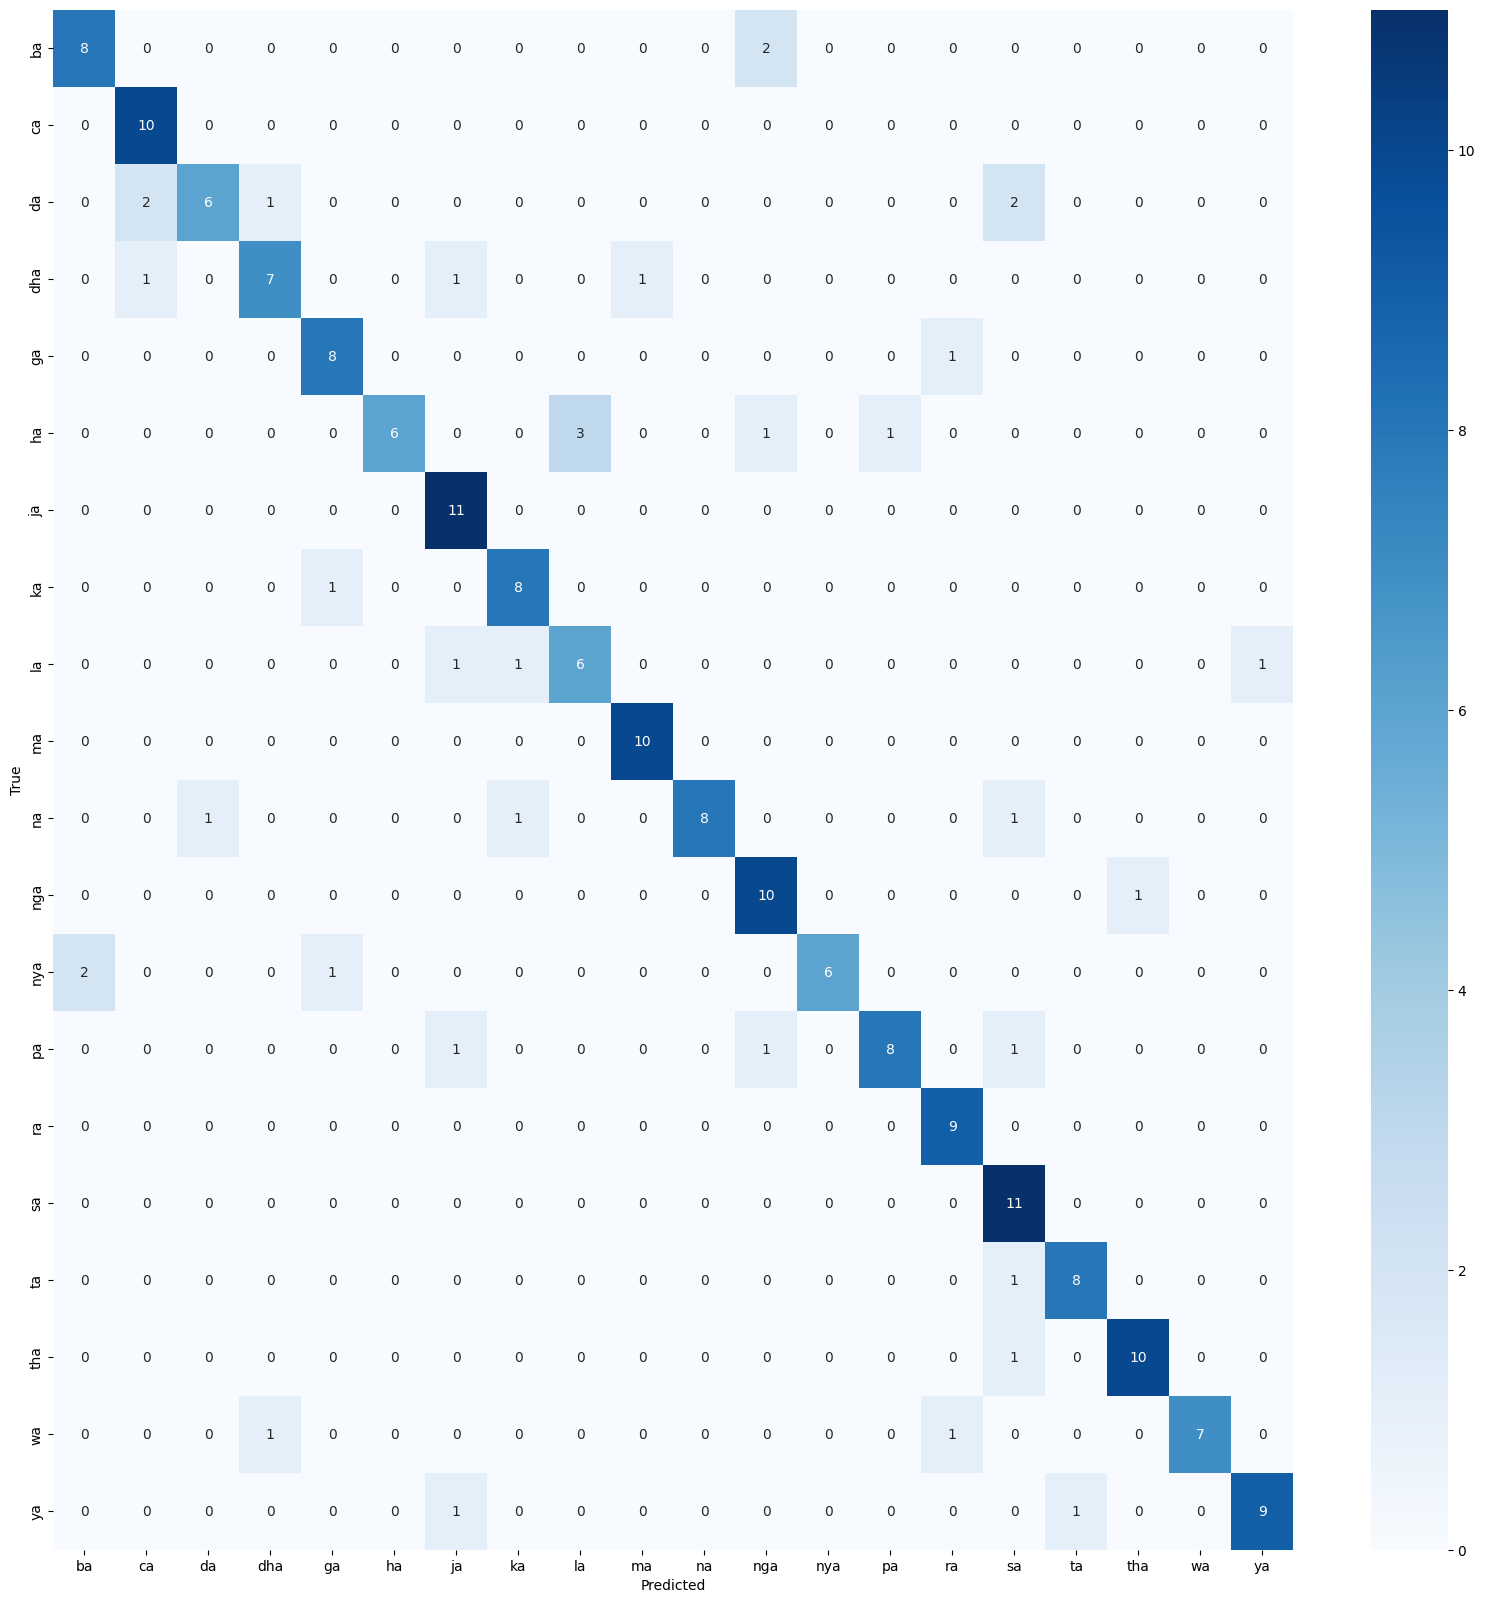

In [164]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## With tf.data.Dataset

In [9]:
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, 
                                                              # labels='inferred', 
                                                              # label_mode='int',
                                                              # image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                              # batch_size=None
                                                              )

test_ds = test_ds.map(load_and_preprocess_image)

Found 202 files belonging to 20 classes.


In [12]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 3s 3s/step


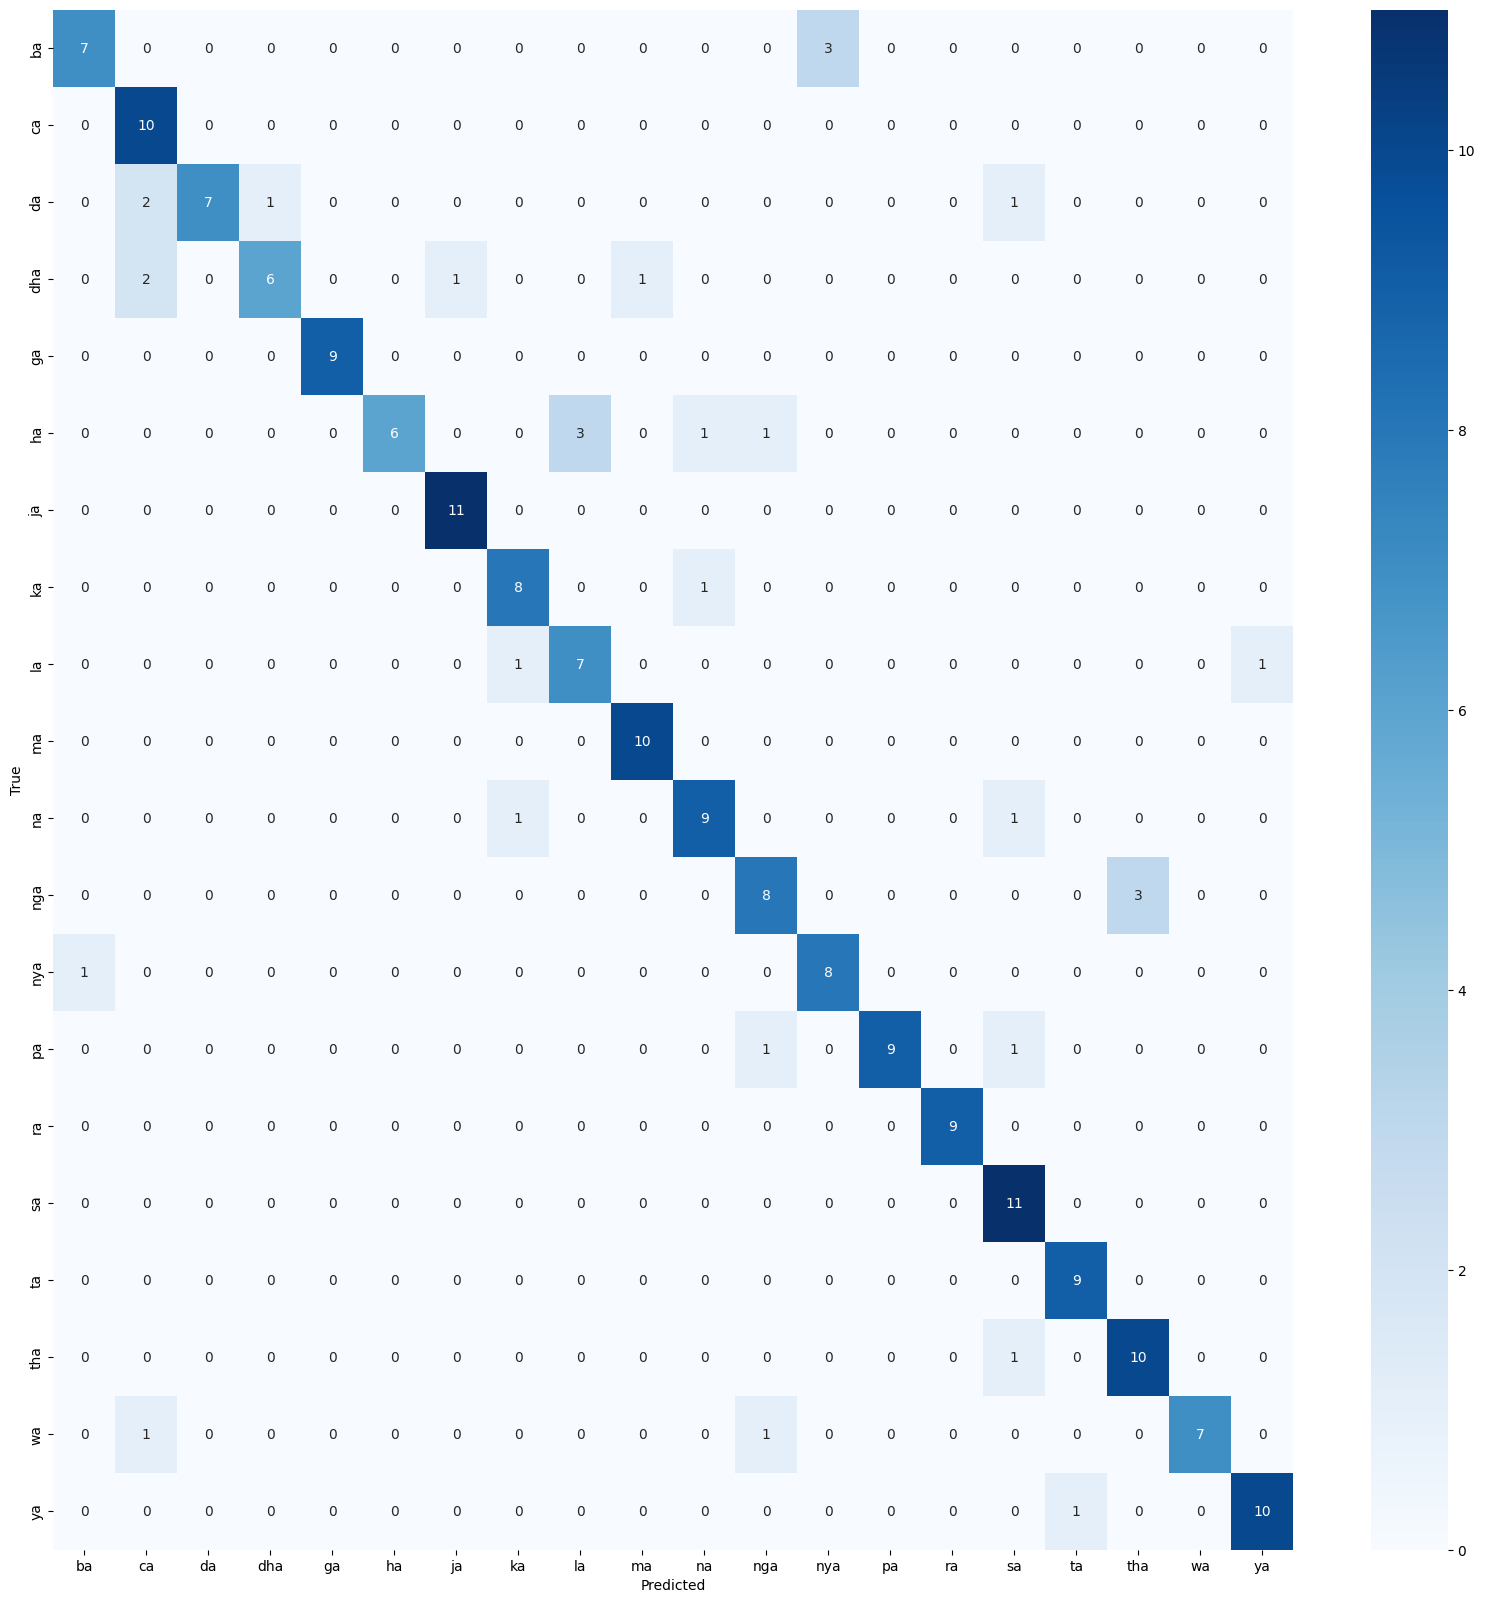

In [14]:
cm = confusion_matrix(correct_labels, predicted_labels)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 [==============================] - 0s 342ms/step


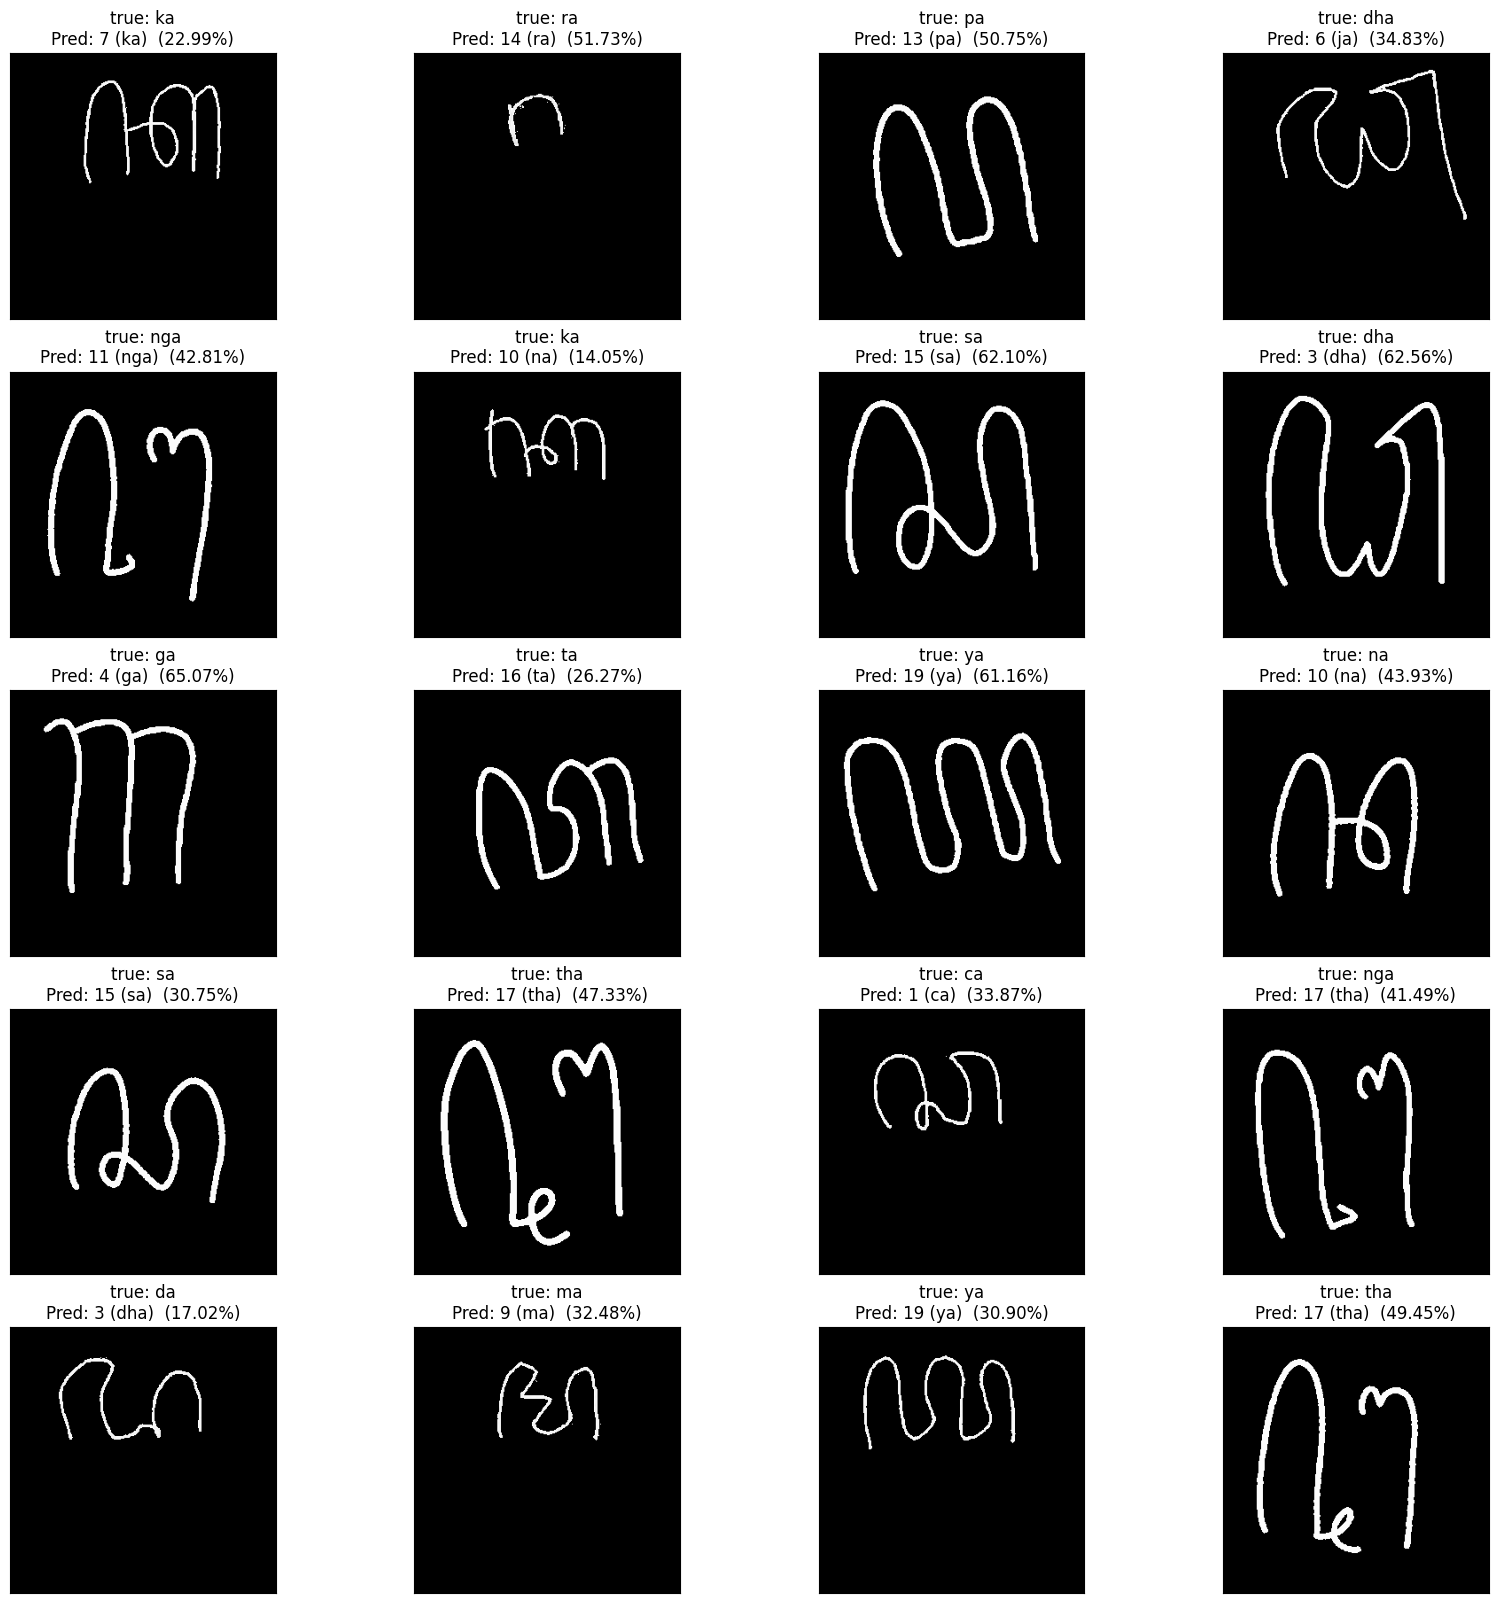

In [15]:
plot_images(test_ds, model=model, n_rows=5)